### Requirements

The following packages need to be installed to import the data.

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import gdown
import zipfile
import gzip
import shutil
import cv2
from sklearn import preprocessing
import math

# Downloading the training and validation data

We use the Automated Cardiac Diagnosis Challenge (ACDC) database. https://acdc.creatis.insa-lyon.fr/#challenges
After signing up the training and validation datasets are available to download. The databases contain a total of 150 MRI scans from different patients, some healthy and some with different conditions. For ease of access and persistence we uploaded the datasets to google drive, from where the script downloads them.

In [ ]:
training_url = 'https://drive.google.com/u/0/uc?id=1FTUNw1gIYjIphJBfF9p-cAEa2fZVz76G&export=download'
testing_url = 'https://drive.google.com/uc?id=1GBSeFwhOutknsu8IBqvjcjdXbjNUF1P5&export=download'

#Download the zips from the given urls
gdown.download(training_url, 'training.zip', quiet=False, verify=False)
gdown.download(testing_url, 'testing.zip', quiet=False, verify=False)

C:\Users\levi2\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\levi2\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\levi2\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn

'testing.zip'

Unzip the training and testing datasets and the scans in them into the train_valid/patients directory. A couple of scans (38, 57, 85, 89, 100, 147) are larger than 256 pixels, so we can not use them.

In [ ]:
os.mkdir('train_valid')

with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall('train_valid')

with zipfile.ZipFile('testing.zip', 'r') as zip_ref:
    zip_ref.extractall('train_valid')

os.mkdir('./train_valid/patients')
os.remove('./train_valid/training/patient001.Info.cfg')
shutil.rmtree('./train_valid/testing/testing')

for subdir in os.listdir('./train_valid/training'):
  with gzip.open(f'./train_valid/training/{subdir}/{subdir}_4d.nii.gz', 'rb') as f_in:
    with open(f'./train_valid/patients/{subdir}.nii', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

for subdir in os.listdir('./train_valid/testing'):
  with gzip.open(f'./train_valid/testing/{subdir}/{subdir}_4d.nii.gz', 'rb') as f_in:
    with open(f'./train_valid/patients/{subdir}.nii', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

shutil.rmtree('./train_valid/training')
shutil.rmtree('./train_valid/testing')
os.remove('./training.zip')
os.remove('./testing.zip')
os.remove('./train_valid/patients/patient038.nii')
os.remove('./train_valid/patients/patient057.nii')
os.remove('./train_valid/patients/patient085.nii')
os.remove('./train_valid/patients/patient089.nii')
os.remove('./train_valid/patients/patient100.nii')
os.remove('./train_valid/patients/patient147.nii')

# Dissecting the 4D scans into 2D images

The scans come as 4D .nii file, which are 3D MRI scans over some time. We unroll the scans into 2D images and add them to an original_images folder. The images will be the reference for the super resolution images. We store the unrolled images in the /train_valid/original_images directory. Note that this operation will take a long time as there will be ~36000 images as the result. This also takes up a considerable amount of disk space ~2GB.

Not all scans come as the same size so we pad them with '0's to make them 256x256 pixels. The few scans larger than 256 pixels have been cleared out before this.

In [ ]:
from numpy.fft import fft, ifft

os.mkdir('./train_valid/original_images')

i = 0
size = len(os.listdir('./train_valid/patients'))

for file in os.listdir('./train_valid/patients'):
    img=nib.load(f'./train_valid/patients/{file}')
    img_data = img.get_fdata()

    for i in range(img.shape[2]):
        #for j in range(img.shape[3]):
        for j in range(3):
            expanded_image = img_data[:, :, i, j]

            #ide jon a scaling
            ft=np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(expanded_image)))
            ft[:75,:]=0
            ft[:,:75]=0
            ft[150:,:]=0
            ft[:,150:]=0

            inverse_tf = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(ft))))))))).real
            
            x_diff = (256 - expanded_image.shape[1]) // 2
            y_diff = (256 - expanded_image.shape[0]) // 2

            expanded_image = np.pad(expanded_image, ((y_diff, y_diff), (x_diff, x_diff)), 'constant')
            downscaled_image = np.pad(inverse_tf, ((y_diff, y_diff), (x_diff, x_diff)), 'constant')

            cv2.imwrite(f'./train_valid/original_images/{file[:-4]}_{i}_{j}.png', expanded_image)
            cv2.imwrite(f'./train_valid/downscaled_images/{file[:-4]}_{i}_{j}.png', downscaled_image)
    
    i += 1
    print('patient', i, '/', size, 'done')

This shows an example of how an original image looks like versus how its 90% scale version looks like. As it can be seen from the axes the original image is 256x256 pixels while the scaled down image is 230x230 pixels.

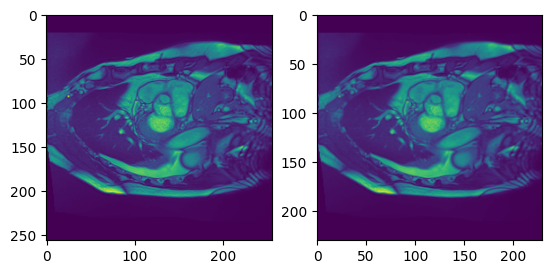

In [ ]:
full_scale = plt.imread('./train_valid/original_images/patient001_0_0.png')
scaled_down = plt.imread('./train_valid/downscaled_images/90_patient001_0_0.png')

plt.subplot(1, 2, 1)
plt.imshow(full_scale)
plt.subplot(1, 2, 2)
plt.imshow(scaled_down)

Creating the training, validation and test datasets with 0.7, 0.2, 0.1 split. Then standardize the data and randomize the training dataset's order. Note that the database is larger (~70000) images, so it will take up a lot of memory ~5GB.

In [ ]:
np.random.seed(2812)

train_split = 0.7
validate_split = 0.2
test_split = 0.1

dataset_path = './train_valid/90percent_scale/'

X = [plt.imread(dataset_path+image) for image in os.listdir(dataset_path)]
Y = [plt.imread('./train_valid/original_images/'+image) for image in os.listdir('./train_valid/original_images/')]

dataset_size = len(X)

train_size = math.ceil(train_split * dataset_size)
validate_size = int(train_size + validate_split * dataset_size)


X_train = X[:train_size]
Y_train = Y[:train_size]
X_valid = X[train_size:validate_size]
Y_valid = Y[train_size:validate_size]
X_test = X[validate_size:]
Y_test  = Y[validate_size:]

scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

randperm = np.random.permutation(len(X_train))
X_train,Y_train = X_train[randperm],Y_train[randperm]

In [ ]:
print('training data set size:', len(X_train), len(X_train[0]))
print('validation data set size:', len(X_valid), len(X_valid[0]))
print('test data set size:', len(X_test), len(X_test[0]))